# **PART 1: DATA COLLECTION**

### Installing package

In [1]:
%%capture 
!pip install imblearn # install imblearn library for data balancing

### Importing packages needed 

In [2]:
import numpy as np # data processing
import pandas as pd # data processing
import os 
import cv2 # For image operations
import random # for shuffling
from typing import List
from matplotlib import pyplot as plt, cm  
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

**Setting up the parameters for Images, Plot, Neural Network and Evaluation of model**

In [3]:
## To Read Images from folders.
H = 150
W = 150
def read_images(path:str, length:int, name:str, recursion:str = r"**/*.png",)-> List[np.ndarray]:
    
    """File path for the folder containing x-ray images"""
    base_dir = Path(path)
    img_paths = list(base_dir.glob(recursion))
    
    images = [] #Image list
    
    print(f"Reading {length} {name} images")
    for i in tqdm(range(length)): 
        image = cv2.imread(str(img_paths[i]), 0) # Read image as grayscale format
        image = cv2.resize(image, (H, W)) # Resize image
        image = image/255. # Normalize image
        images.append(image) # Add to image folder
        
    print(f"{len(images)} {name} images processed.")
    
    return images


## To Plot. 
def plot(images:List[np.ndarray], name:str, nrows:int = 3, ncols:int = 4)-> None:
    """Plots for a single class"""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})
    for ax in axes.flat:
        y = np.random.randint(len(images))
        ax.imshow(images[y], interpolation='nearest', cmap=cm.Greys_r)
        ax.set_title(name)

    plt.show()
    
    
def multi_plot(images:List[np.ndarray], labels:List[str], nrows:int = 3, ncols:int = 4) -> None:
    """Plots for multiple classes"""
    label = ['Knee', 'Chest', 'Wrist']
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})
    for ax in axes.flat:
        y = np.random.randint(len(images))
        ax.imshow(data[y], interpolation='nearest', cmap=cm.Greys_r)
        label_i = label[labels[y]]
        ax.set_title(label_i)

    plt.show()
    
    

## For Neural Network modelling.
def NN_model(input_shape):
    
    model = keras.Sequential()
    
    model.add(layers.Input(input_shape))
    model.add(layers.Conv2D(32, 7))
    model.add(layers.BatchNormalization(3))
    model.add(layers.Activation('relu'))
    
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Conv2D(64, 5, padding='same'))
    model.add(layers.BatchNormalization(3))
    model.add(layers.Activation('relu'))
    
    model.add(layers.MaxPooling2D(3,))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    
    model.summary()
    
    return model


## For-Model Evaluation.


model_name = []
recall = []
precision = []
f1 = []
description = []

def evaluate_model(y_test:List[int], y_preds:List[int]):
    
    ## F1-Score
    f1_eval = f1_score(y_test, y_preds, average='macro')
    f1.append(f1_eval)
    print(f'The F1-Score is: {f1_eval}')
    
    ## Precision score
    precision_eval = precision_score(y_test, y_preds, average='macro') 
    precision.append(precision_eval)
    print(f'The Precision-Score is: {precision_eval}')

    ## Recall score
    recall_eval = recall_score(y_test, y_preds, average='macro') 
    recall.append(recall_eval)
    print(f'The Recall-Score is: {recall_eval}')

### **Chest Images**

**The 1600 chest images were gotten from the train set folder in https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset on kaggle.**

In [4]:

chest_dir = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train' 

chest_images = read_images(chest_dir, 1600, 'chest', r'*.jpeg')

Reading 1600 chest images


100%|██████████| 1600/1600 [00:27<00:00, 58.40it/s]

1600 chest images processed.


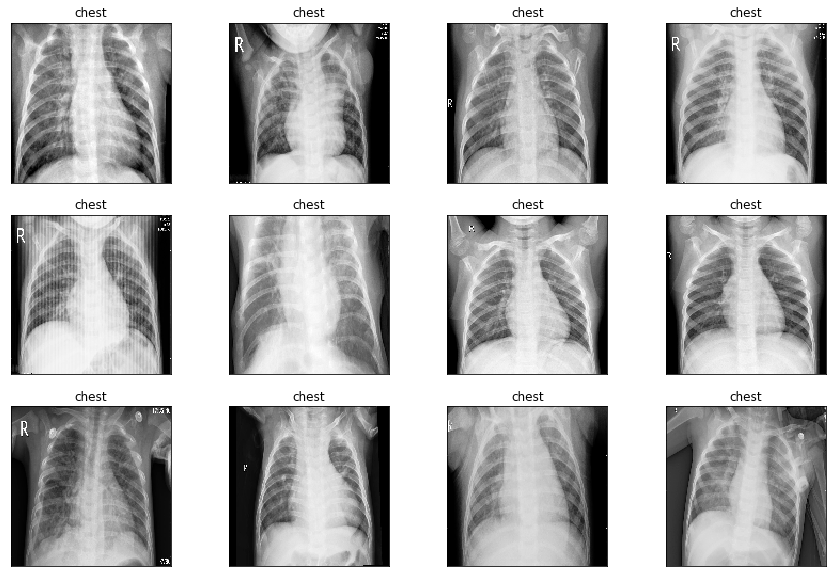

In [5]:
plot(chest_images, 'chest')

### **Wrist Images**

**The 2000 wrist images were gotten from test dataset in https://www.kaggle.com/kmader/rsna-bone-age on kaggle.**

In [6]:
wrist_dir = '../input/rsna-bone-age/boneage-training-dataset'

wrist_images = read_images(wrist_dir, 2000, 'wrist')

Reading 2000 wrist images


100%|██████████| 2000/2000 [01:14<00:00, 26.76it/s]

2000 wrist images processed.


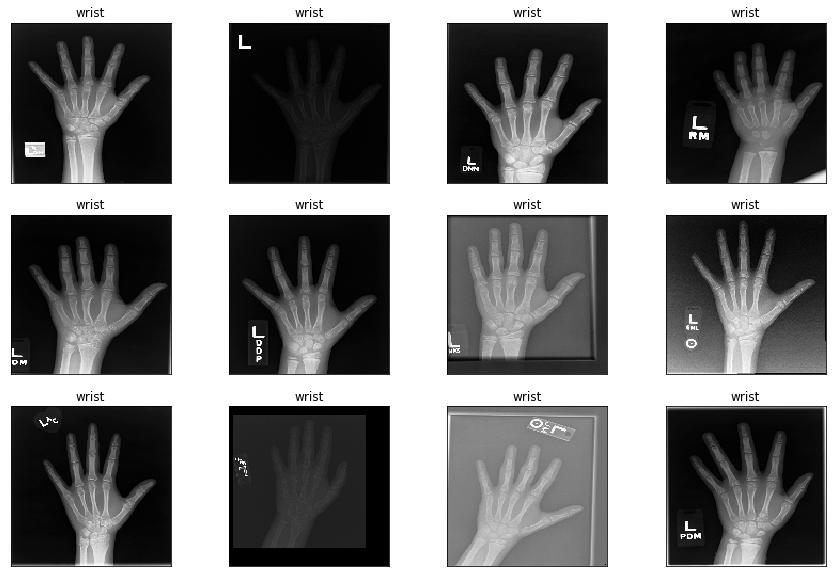

In [7]:
plot(wrist_images, 'wrist')

### **Knee Images**

**The 1000 knee images were gotten from MedicalExpert-I folder in https://www.kaggle.com/tommyngx/digital-knee-xray on kaggle.  
Kindly note that these images has not been classified as  test or train dataset**

In [8]:
knee_dir = '../input/digital-knee-xray' 

knee_images = read_images(knee_dir, 1000, 'Knee')

Reading 1000 Knee images


100%|██████████| 1000/1000 [00:08<00:00, 121.73it/s]

1000 Knee images processed.


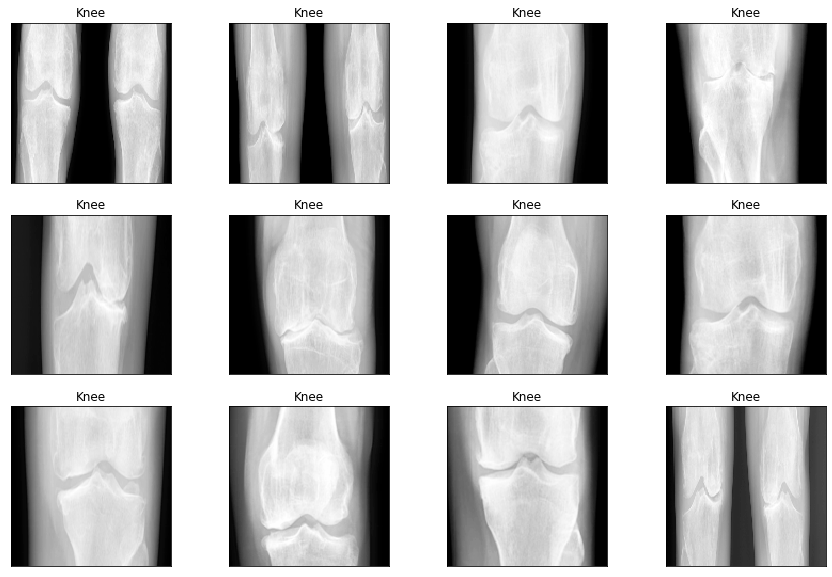

In [9]:
plot(knee_images, 'Knee')

## **Visualizations**

### **Pie chart displaying data distribution**

In [10]:
df = pd.DataFrame({
    'labels': ['knee', 'chest', 'wrist'],
    'count': [len(knee_images), len(chest_images), len(wrist_images)]
})
df 

,labels,count
0,knee,1000
1,chest,1600
2,wrist,2000


Pie chart to display data distribution

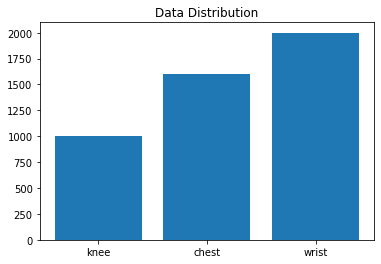

In [11]:
plt.bar(df.labels, df['count'])
plt.title('Data Distribution')
plt.show()

## **Data Combination**  
Here I will combine the different images (chest, wrist and knee) into a single numpy array for preprocessing and validation

In [12]:
np.random.seed(412) # Setting a seed to control the output.

data = np.array(knee_images + chest_images + wrist_images)  # This is to Combine the images

labels = np.array([0]*1000 + [1]*1600 +[2]*2000) 

length = data.shape[0] # length of the data

# Shuffling the data and labels
indx = np.arange(length) 
np.random.shuffle(indx)

data = data[indx]
labels = labels[indx]


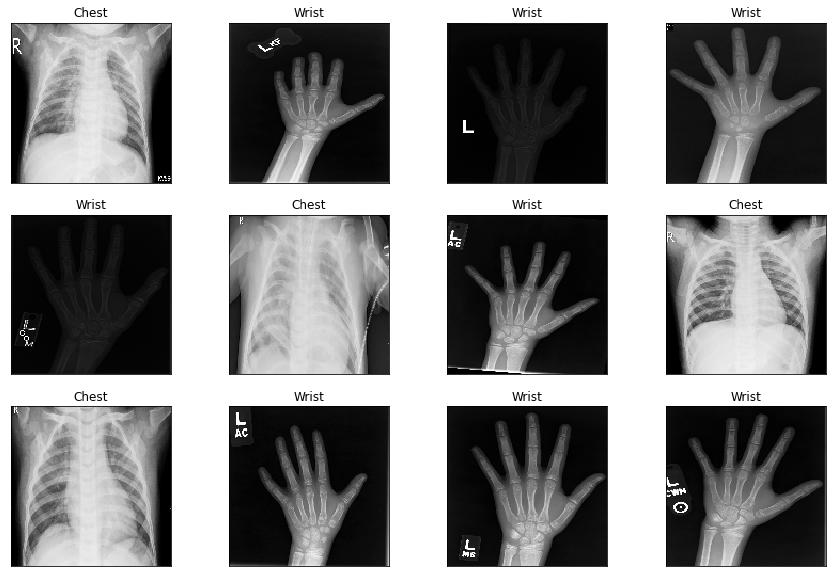

In [13]:
# Visual display of the different classes of X-ray images

multi_plot(data, labels)

# **PART 2: VALIDATION**

# **2a: Model (Neural Network) Training and Validation** 
Classification of the test set with the starting dataset unaltered and using a neural
network-based machine learning architecture.


In [14]:
# This is to split data into 70:30 ratio for train-set and test-set
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=412, test_size=0.3, stratify=labels, shuffle=True)

In [15]:
# This is to create array format for keras
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

# reshaping the data to specify the channel
X_train = X_train.reshape(X_train.shape[0], 150, 150, 1)
X_test = X_test.reshape(X_test.shape[0], 150, 150, 1)

In [16]:
# Setting a seed to control randomness of the output
np.random.seed(412)
tf.random.set_seed(412)

# model summary
model = NN_model(X_train.shape[1:])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 144, 32)      1600      
_________________________________________________________________
batch_normalization (BatchNo (None, 144, 144, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 144, 144, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0

2022-04-22 09:37:44.474436: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [17]:
# Setting a seed to control randomness values to be generated
np.random.seed(412)
tf.random.set_seed(412)

# model training; 5 iterations
epochs = 5
batch_size=32

training_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

2022-04-22 09:37:46.527564: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
101/101 [==============================] - 44s 420ms/step - loss: 0.2038 - accuracy: 0.9584 - val_loss: 0.2658 - val_accuracy: 0.8790
Epoch 2/5
101/101 [==============================] - 40s 398ms/step - loss: 0.0504 - accuracy: 0.9894 - val_loss: 0.1787 - val_accuracy: 0.9507
Epoch 3/5
101/101 [==============================] - 40s 395ms/step - loss: 0.0539 - accuracy: 0.9904 - val_loss: 0.0841 - val_accuracy: 0.9696
Epoch 4/5
101/101 [==============================] - 40s 400ms/step - loss: 0.0070 - accuracy: 0.9972 - val_loss: 0.0437 - val_accuracy: 0.9891
Epoch 5/5
101/101 [==============================] - 41s 405ms/step - loss: 0.0216 - accuracy: 0.9969 - val_loss: 0.1644 - val_accuracy: 0.9768


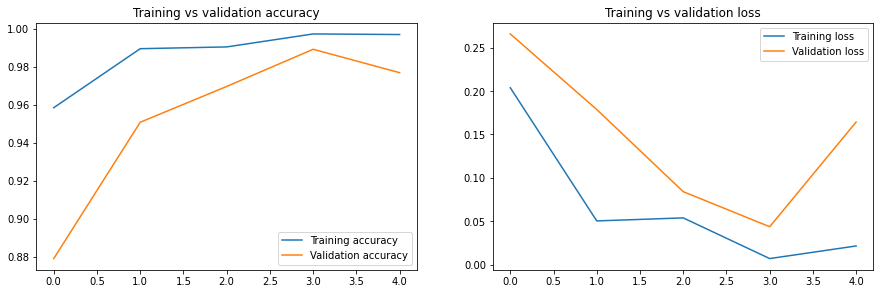

In [18]:
# Visualizing the training report

accuracy = training_history.history['accuracy']
val_accuracy  = training_history.history['val_accuracy']

loss = training_history.history['loss']
val_loss = training_history.history['val_loss']


plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [19]:
# Evaluating the model on the test data
y_test = np.argmax(y_test, axis=1)
y_preds = np.argmax(model.predict(X_test), axis=1).tolist()

## Evaluate model performance

model_name.append('NN Architecture(1)')
description.append('NN Architecture(1): This model performed very well across the different metrics and is trained for 7 epochs')
evaluate_model(y_test, y_preds)

The F1-Score is: 0.9727559120127532
The Precision-Score is: 0.9686783187910394
The Recall-Score is: 0.9784722222222223


# **2b. Image Augmentation**
Balancing the classes of the training data (e.g. using image augmentation) and
classification of the test set using a neural network-based machine learning
architecture.

In [20]:

def augmentor(image, seed):
    """ Augment images using tensorflow's image manipulation functions to rotate, flip, crop and increase brightness"""
    # rotate image 
    rotated_image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # flip left or right and up or down
    flipped_image = tf.image.random_flip_left_right(image)
    flipped_image = tf.image.random_flip_up_down(flipped_image)
    # randomly crop image
    cropped_image = tf.image.stateless_random_crop(image, size=[150, 150, 1], seed=(seed, 0))
    # adjust image brightness
    adj_brightness_image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=(seed, 0))
    
    return [rotated_image, flipped_image, cropped_image, adj_brightness_image]
    
    

100%|██████████| 100/100 [00:00<00:00, 246.66it/s]


400 new images generated


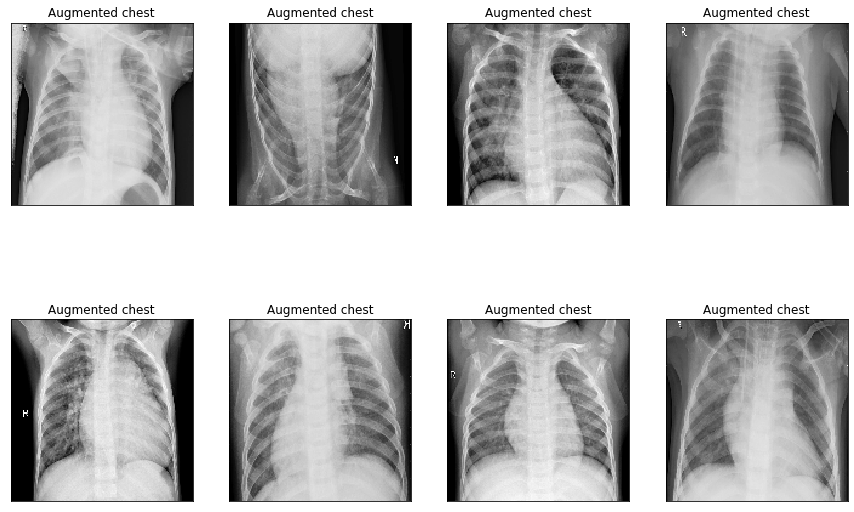

In [21]:
chest_array = np.array(chest_images) # This is to convert chest list into numpy array
chest_array = chest_array.reshape(chest_array.shape[0], 150, 150, 1) # I reshape to specify number of channels 

chest_aug = [] # This list we store the augmented images
for i in tqdm(range(100)): 
    """This loop iterates 100 times. At each iteration, 4 new images are generated leading to 400 new images """
    random.randint(0, 1600)
    chest_aug.extend(augmentor(chest_array[i], seed=412))
    
print(f"{len(chest_aug)} new images generated")

# Visualization of the augmented chest images 

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})
label = 'Augmented chest'
for ax in axes.flat:
    y = np.random.randint(len(chest_aug))
    ax.imshow(chest_aug[y], interpolation='nearest', cmap=cm.Greys_r)
    ax.set_title(label)
    
plt.show()

100%|██████████| 250/250 [00:00<00:00, 254.98it/s]


1000 images generated


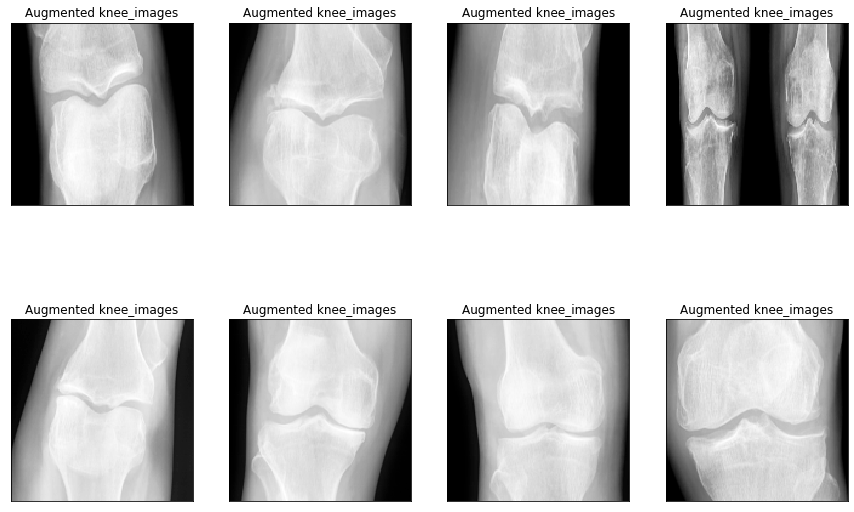

In [22]:
knee_array = np.array(knee_images) # This is to convert knee list into numpy array
knee_array = knee_array.reshape(knee_array.shape[0], 150,150, 1)  # I will reshape to specify number of channels 

knee_aug = [] # This list will store augmented images
for i in tqdm(range(250)):
    """This loop iterates 250 times, at each iteration 4 images are generated leading to 250 * 4 = 1000 new images """
    random.randint(0, 100)
    knee_aug.extend(augmentor(knee_array[i], seed=412))
    
print(f"{len(knee_aug)} images generated")    

# Visualization of the augmented wrist images 
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})
label = 'Augmented knee_images'
for ax in axes.flat:
    y = np.random.randint(len(knee_aug))
    ax.imshow(knee_aug[y], interpolation='nearest', cmap=cm.Greys_r)
    ax.set_title(label)
    
plt.show()

In [23]:
# Here, I will concatenate augmented images and original images 
knee_array = np.concatenate([knee_array, knee_aug])
chest_array = np.concatenate([chest_array, chest_aug])

wrist_array = np.array(wrist_images).reshape(len(wrist_images), 150, 150, 1) # This is to convert chest list to numpy array and reshape to specify channels

balanced_data = np.concatenate([knee_array, chest_array, wrist_array])  # This is now my concatenated balanced dataset
balanced_labels = np.array([0]*2000 + [1]*2000 + [2]*2000) # labels for the balanced dataset

del knee_aug, chest_aug, chest_array, wrist_array, knee_array # To remove variables that are no longer needed
print(f'The shape of the data set is now {balanced_data.shape}, consisting of {balanced_labels.shape} number of labels')

The shape of the data set is now (6000, 150, 150, 1), consisting of (6000,) number of labels


In [24]:
# To remove variables that are no longer needed
del chest_images, wrist_images, knee_images

In [25]:
# This is to split data into 70:30 ratio for train-set and test-set
X_train, X_test, y_train, y_test = train_test_split(balanced_data, balanced_labels, random_state=150, test_size=0.3, stratify=balanced_labels, shuffle=True)

In [26]:
# This is to create array format for keras
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)


print(X_train.shape, y_train.shape)

(4200, 150, 150, 1) (4200, 3)


In [27]:
# Setting seed to control randomness of values to be generated
np.random.seed(150)
tf.random.set_seed(150)

# model summary
model = NN_model(X_train.shape[1:])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 144, 144, 32)      1600      
_________________________________________________________________
batch_normalization_2 (Batch (None, 144, 144, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 144, 144, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        51264     
_________________________________________________________________
batch_normalization_3 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 48, 48, 64)       

In [28]:
# Setting random seed to control randomness of the output
np.random.seed(150)
tf.random.set_seed(150)

# model training; 10 iterations
eps = 5
batch_size=32

training_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=eps, validation_data=(X_test, y_test))

Epoch 1/5
132/132 [==============================] - 54s 403ms/step - loss: 0.4065 - accuracy: 0.9300 - val_loss: 1.3776 - val_accuracy: 0.6506
Epoch 2/5
132/132 [==============================] - 53s 401ms/step - loss: 0.0335 - accuracy: 0.9895 - val_loss: 0.6020 - val_accuracy: 0.7661
Epoch 3/5
132/132 [==============================] - 53s 403ms/step - loss: 0.0240 - accuracy: 0.9919 - val_loss: 1.1202 - val_accuracy: 0.7378
Epoch 4/5
132/132 [==============================] - 53s 404ms/step - loss: 0.0109 - accuracy: 0.9964 - val_loss: 0.0584 - val_accuracy: 0.9833
Epoch 5/5
132/132 [==============================] - 53s 404ms/step - loss: 0.0153 - accuracy: 0.9948 - val_loss: 0.0636 - val_accuracy: 0.9789


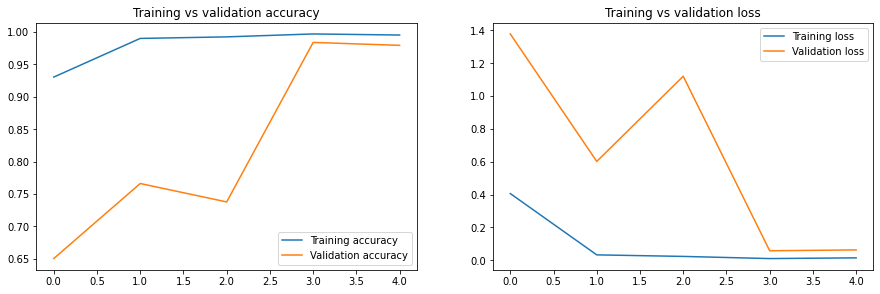

In [29]:
# Visualizing the training report

accuracy = training_history.history['accuracy']
val_accuracy  = training_history.history['val_accuracy']

loss = training_history.history['loss']
val_loss = training_history.history['val_loss']


plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [30]:
# Evaluating the model on the test data
y_test = np.argmax(y_test, axis=1)
y_preds = np.argmax(model.predict(X_test), axis=1).tolist()

model_name.append('NN Architecture(2)')
description.append('NN Architecture(2):The least underperforming was the model trained on augmented data. Trained 10 epochs')
evaluate_model(y_test, y_preds)

The F1-Score is: 0.9789364244400244
The Precision-Score is: 0.9794263294720958
The Recall-Score is: 0.9788888888888888


In [31]:
del balanced_data, balanced_labels # removing variables no longer needed

# **2c. Feature Extraction**  
Feature extraction of the starting dataset (e.g. Harris, SIFT, SURF, HOG, etc.), and
classification of the test set using any machine learning architecture (e.g. NN, CNN,
SVM, Random Forests, Naïve Bayes, etc.)


In [32]:
from skimage import feature, exposure # For Histogram of Oriented Gradients
from sklearn.ensemble import RandomForestClassifier  # Machine learning model

In [33]:
# I will apply HOG filter across the data pixels
def HOG(data):
    hog_images = [] # store extracted pixels
    for img in tqdm(data):
        # Apply HOG filter
        fd, hog_pixels = feature.hog(img, orientations=9, pixels_per_cell=(8, 8), 
                            cells_per_block=(2, 2), visualize=True, multichannel=True)
        hog_pixels = exposure.rescale_intensity(hog_pixels, in_range=(0, 10)) 
        hog_images.append(hog_pixels)
    return np.array(hog_images)

##  Application of Histogram of Oriented gradient for feature extraction
extracted_features = HOG(data.reshape(data.shape[0], 150, 150, 1)) 
extracted_features.shape

  0%|          | 0/4600 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  import sys
100%|██████████| 4600/4600 [05:56<00:00, 12.91it/s]


(4600, 150, 150)

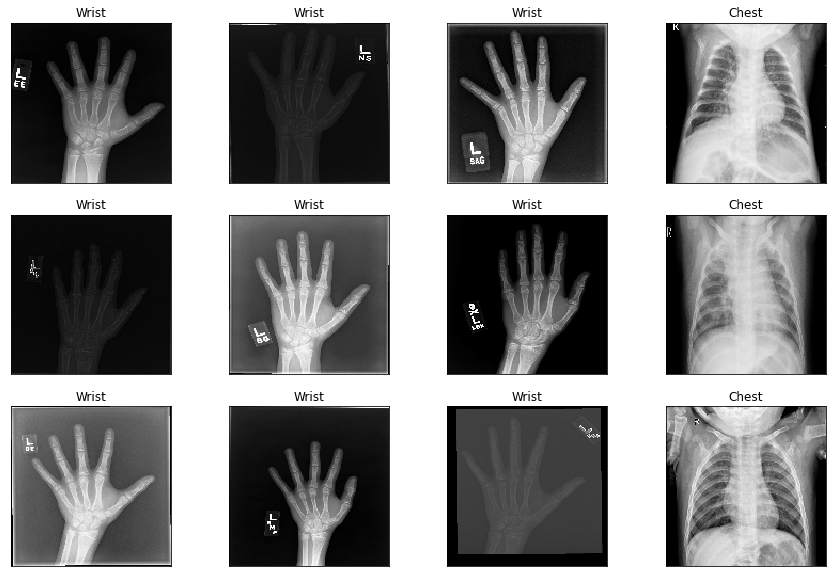

In [34]:
# Visualization of HOG feature extracted
multi_plot(extracted_features, labels)

In [35]:
# This is to split the data into 70:30 ratio for train set and test set 
X_train, X_test, y_train, y_test = train_test_split(extracted_features, labels, random_state=150, test_size=0.3, stratify=labels, shuffle=True)

# 2 dimensions reshaping of  data for machine learning model
X_train = X_train.reshape(X_train.shape[0], 150*150*1) 
X_test = X_test.reshape(X_test.shape[0], 150*150*1)

X_train.shape, X_test.shape

((3220, 22500), (1380, 22500))

In [36]:
# Machine Learning [Support Vector Classifier]
model = RandomForestClassifier() 
model.fit(X_train, y_train) # Model training
y_preds = model.predict(X_test).tolist() # predicitions

model_name.append('RandomForest (HOG)')
description.append('RandomForest (HOG): This is also a good performance model with F1- score, Precision-score and Recall- score above 99%.')
evaluate_model(y_test, y_preds)

The F1-Score is: 0.9972899681918702
The Precision-Score is: 0.9974991714122149
The Recall-Score is: 0.9970833333333333


# **2d. Data Undersampling**  
 Feature extraction of the starting dataset (preferably the same used in c.), data
balancing of the training dataset (e.g. oversampling, undersampling, class
decomposition, etc.) and classification using any machine learning architecture
(e.g. NN, CNN, SVM, Random Forests, Naïve Bayes, etc.)




In [37]:
# To import Random Undersampler from imblearn
from imblearn.under_sampling import RandomUnderSampler

In [38]:
ros = RandomUnderSampler(random_state=150) 
hog_undersampled, target_undersampled = ros.fit_resample(X_train, y_train) 

In [39]:
"""Model Training and Evaluation"""

model = RandomForestClassifier() # instantiate model
model.fit(hog_undersampled, target_undersampled) # fit upon data
y_preds = model.predict(X_test).tolist() # predictions


model_name.append('RandomForest [Undersampled]')
description.append('RandomForest [Undersampled]: This model performed very well with F1- score, Precision-score and Recall- score above 99%.')
evaluate_model(y_test, y_preds)

The F1-Score is: 0.997296693127882
The Precision-Score is: 0.9966996699669967
The Recall-Score is: 0.9979166666666667


# **Results**

In [40]:
evaluation = pd.DataFrame({'model': model_name,
                        'F1-Score': f1,
                        'Precision': precision,
                        'Recall': recall,
                        'Desc': description
                       })

In [41]:
evaluation.style.set_properties(subset=['Desc'], **{'width': '500px'}) # increase column width

,model,F1-Score,Precision,Recall,Desc
0,NN Architecture(1),0.972756,0.968678,0.978472,NN Architecture(1): This model performed very well across the different metrics and is trained for 7 epochs
1,NN Architecture(2),0.978936,0.979426,0.978889,NN Architecture(2):The least underperforming was the model trained on augmented data. Trained 10 epochs
2,RandomForest (HOG),0.997290,0.997499,0.997083,"RandomForest (HOG): This is also a good performance model with F1- score, Precision-score and Recall- score above 99%."
3,RandomForest [Undersampled],0.997297,0.996700,0.997917,"RandomForest [Undersampled]: This model performed very well with F1- score, Precision-score and Recall- score above 99%."


In [42]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(14,6)})

def bar_plot(column):
    sns.barplot(x="model", y=column, data=evaluation)
    plt.show()

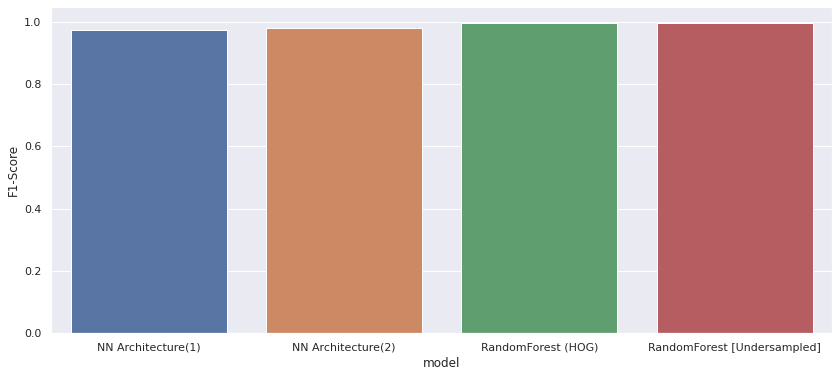

In [43]:
# F1-Score 
bar_plot("F1-Score")

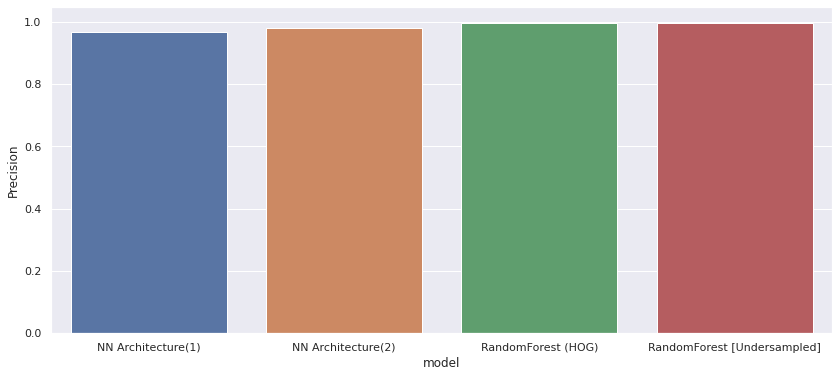

In [44]:
# Precision
bar_plot("Precision")

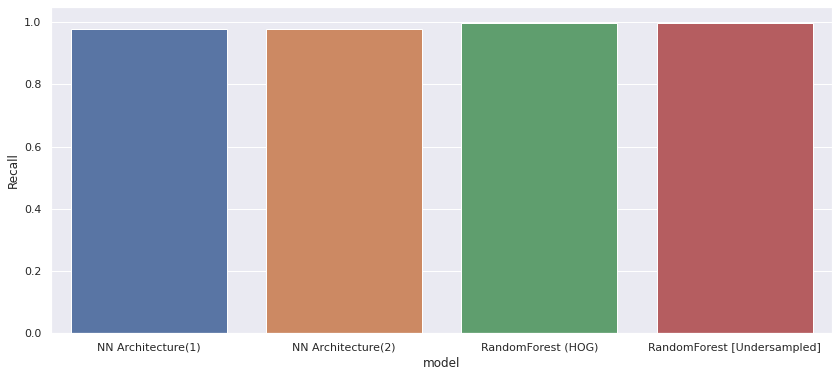

In [45]:
# Recall
bar_plot("Recall")

### **Report Summary**
Each class contains:  

| Class 	| Size 	|  
|-------	|------	|  
| Chest 	| 1600 	|  
| Knee  	| 1000 	| 
| Wrist 	| 2000 	|  


Data Preprocessing:
> Conversion of images to grayscale  
> Pixel normalization  
> Feaure extraction  
> Image augmentation 


* From our report and plots, the models perform excellently well across the diffrent experiments.  
* Our NN architecture for the first experiment had the best performance across the different metrics. 
* The least underperforming was the model trained on augmented data.

### References

www.kaggle.com. (n.d.). Digital Knee X-ray. [online] Available at: https://www.kaggle.com/datasets/tommyngx/digital-knee-xray?select=MedicalExpert-I.

www.kaggle.com. (n.d.). CoronaHack -Chest X-Ray-Dataset. [online] Available at: https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset.

kaggle.com. (n.d.). RSNA Bone Age. [online] Available at: https://www.kaggle.com/kmader/rsna-bone-age.

www.youtube.com. (n.d.). Machine Learning Foundations: Ep #7 - Image augmentation and overfitting. [online] Available at: https://www.youtube.com/watch?v=QWdYWwW6OAE



